Source of data sets:
- covid-19 related datasets: https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset/discussion/136061
- population_by_country: https://www.kaggle.com/tanuprabhu/population-by-country-2020

In [142]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt

#import requests, zipfile

import geopandas as gpd
import descartes


%matplotlib inline
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [143]:
def extract_data(file_name, file_path):
    !kaggle datasets download -d sudalairajkumar/novel-corona-virus-2019-dataset -f $file_name -p $file_path --force

In [144]:
# file names

file_name = 'covid_19_data.csv'

# file paths

data_path = os.path.join(os.path.curdir, 'data')
#data_path = os.path.join(os.path.pardir, 'web_app', 'data')

# download data file

extract_data(file_name, data_path)

100%|████████████████████████████████████████| 866k/866k [00:00<00:00, 5.66MB/s]
100%|████████████████████████████████████████| 866k/866k [00:00<00:00, 5.64MB/s]


In [13]:
keepcolumns = ['Country Name', '1990', '2015']
value_variables = ['1990', '2015']

#test_raw = test_raw[keepcolumns]

#top10country = ['United States', 'China', 'Japan', 'Germany', 'United Kingdom', 'India', 'France', 'Brazil', 'Italy', 'Canada']
    
#test_raw = test_raw[test_raw['Country Name'].isin(top10country)]

# melt year columns  and convert year to date time
#test_melt = test_raw.melt(id_vars='Country Name', value_vars = value_variables)
#test_melt.columns = ['country','year', 'variable']
#test_melt['year'] = test_melt['year'].astype('datetime64[ns]')

#test_melt

In [14]:
def df_prepare(dataset, pop_dataset=None, historical=False, continent=None, top_n = None):
    
    '''
    Clean data, join with population data (optional) and return dataframe.
    
    Args:
        dataset (str): path of the csv data file
        
        
    Return:
    
        df (DataFrame): pre-prepared data for geoplot / clean data for barplot and timeplot
        
    '''
    
    
    
    # read datasets
    
    df = pd.read_csv(dataset) #
    
    if pop_dataset:
        
        df_pop = pd.read_csv(pop_dataset, delimiter=";") # population dataset
        
    
    # clean data
    
    df = df.rename(columns={"ObservationDate": "Date", "Country/Region": "Country"})
    
    df = df.groupby(['Country', 'Date']).sum().reset_index()
    
    
    df['Country'] = df['Country'].replace({'UK': 'United Kingdom', 
                                           'US': 'United States', 
                                           'Mainland China': 'China',
                                           'Czech Republic': 'Czechia',
                                           })
    
    
    
    if pop_dataset:
    
        df = df.set_index('Country').join(df_pop.set_index('Country'))
        df.dropna(subset=['Population'], inplace=True)
        
        df['Infected'] = df['Confirmed'] - df['Recovered'] - df['Deaths']
        
        df['Confirmed_percent'] = 100*df['Confirmed']/(df['Population'] + 1.0)
        df['Recovered_percent'] = 100*df['Recovered']/(df['Population'] + 1.0)
        df['Deaths_percent'] = 100*df['Deaths']/(df['Population'] + 1.0)
        df['Infected_percent'] = 100*df['Infected']/(df['Population'] + 1.0)
        
        df['Confirmed_per_100k'] = 100000*df['Confirmed']/(df['Population'] + 1.0)
        df['Recovered_per_100k'] = 100000*df['Recovered']/(df['Population'] + 1.0)
        df['Deaths_per_100k'] = 100000*df['Deaths']/(df['Population'] + 1.0)
        df['Infected_per_100k'] = 100000*df['Infected']/(df['Population'] + 1.0)
    
    # filter/select data based on continent, selected_countries and historical
    
        if continent:
            df = df[df['Continent'] == continent]
    
    #df = df.loc[df.index.isin(selected_countries), :]
    
    df = df.reset_index().set_index('Date')
    df.index = pd.to_datetime(df.index, infer_datetime_format=True)
    
    if historical:
        
        df = df.query("index >= '2020-02-20'")
        df = df[['Continent', 'Country', 'Population', 'Infected', 'Recovered', 'Deaths', 
                 'Infected_percent', 'Recovered_percent', 'Deaths_percent',
                 'Infected_per_100k', 'Recovered_per_100k', 'Deaths_per_100k']]
        
    else:
    
        df = df[df.index == df.index.max()]
        if pop_dataset:
            df = df[['Continent', 'Country', 'Short', 'Population', 'Infected', 'Recovered', 'Deaths', 
                     'Infected_percent', 'Recovered_percent', 'Deaths_percent',
                     'Infected_per_100k', 'Recovered_per_100k', 'Deaths_per_100k']]
            
            df = df.reset_index().set_index('Country')
        else:
            df = df[['Continent', 'Country', 'Population', 'Infected', 'Recovered', 'Deaths', 
                     'Infected_percent', 'Recovered_percent', 'Deaths_percent',
                     'Infected_per_100k', 'Recovered_per_100k', 'Deaths_per_100k']]
            
            df = df.reset_index().set_index('Country')
    
    
    return df
    

In [135]:
df_01 = df_prepare('data/covid_19_data.csv', 'data/population_2020_for_johnhopkins_data.csv',
                    historical = False,
                    continent = None)

In [138]:
df_01.Infected.sort_values()

Country
Papua New Guinea         2.0
Burundi                  3.0
South Sudan              3.0
Mauritania               4.0
Nicaragua                6.0
                      ...   
Germany              63167.0
France               83140.0
Spain                85610.0
Italy                96877.0
United States       419549.0
Name: Infected, Length: 141, dtype: float64

In [15]:
def plot_bar(var, continent = None, top_n = None):

    var_list_abs = ['Infected', 'Recovered', 'Deaths']
    var_list_rel1 = ['Infected_percent', 'Recovered_percent', 'Deaths_percent']
    var_list_rel2 = ['Infected_per_100k', 'Recovered_per_100k', 'Deaths_per_100k']

    continent_list = ['America', 'Europe', 'Asia', 'Africa', 'Oceania']

    if continent:
        assert continent in continent_list
    
    
    keyword1 = '_percent'
    keyword2 = '_per_100k'

    if keyword1 in var:
        
        stat = '(relative to population)'
        var_list = var_list_rel1
    
    elif keyword2 in var:
        
        stat = '(relative to population)'
        var_list = var_list_rel2
    
    else:
        stat = ''
        var_list = var_list_abs
        

    df = df_prepare('data/covid_19_data.csv', 'data/population_2020_for_johnhopkins_data.csv',
                    historical = False,
                    continent = continent)


    if continent == 'Oceania':
        fig_width = 5
    else:
        fig_width = 20
        
    if top_n:
        tot_countries = df.shape[0]
        if top_n > tot_countries:
            top_n = tot_countries
            
    if not continent:
        continent = "The World"
    
    df.sort_values(by=[var], ascending=False).loc[:, var_list][:top_n].plot.bar(
        title = '{}: Number of Infected, Recovered, Deaths {}'.format(continent, stat), 
        stacked = False,
        colormap='tab20b',
        figsize=(fig_width, 5)
        )
    
    plt.xticks(rotation=20)
    plt.legend(loc='upper right');
    
    #return df

In [16]:
def plot_bar2(var, continent = None, top_n = None):

    var_list_abs = ['Infected', 'Recovered', 'Deaths']
    var_list_rel1 = ['Infected_percent', 'Recovered_percent', 'Deaths_percent']
    var_list_rel2 = ['Infected_per_100k', 'Recovered_per_100k', 'Deaths_per_100k']

    continent_list = ['America', 'Europe', 'Asia', 'Africa', 'Oceania']

    if continent:
        assert continent in continent_list
    
    
    keyword1 = '_percent'
    keyword2 = '_per_100k'

    if keyword1 in var:
        
        stat = '(relative to population)'
        var_list = var_list_rel1
    
    elif keyword2 in var:
        
        stat = '(relative to population)'
        var_list = var_list_rel2
    
    else:
        stat = ''
        var_list = var_list_abs
        

    df = df_prepare('data/covid_19_data.csv', 'data/population_2020_for_johnhopkins_data.csv',
                    historical = False,
                    continent = continent)
        
    if top_n:
        tot_countries = df.shape[0]
        if top_n > tot_countries:
            top_n = tot_countries
            
    if not continent:
        continent = "The World"
    
    df = df.sort_values(by=[var], ascending=False).loc[:, var_list][:top_n].reset_index()
    
    return df

In [17]:
df_all = plot_bar2('Infected_per_100k', continent = '', top_n = 20)
df_all

,Country,Infected_per_100k,Recovered_per_100k,Deaths_per_100k
0,Luxembourg,397.457423,79.874884,7.348489
1,Iceland,286.305400,185.497767,1.758273
2,Spain,182.670097,102.708217,31.637408
3,Italy,157.557263,43.814422,29.223397
4,Switzerland,145.413613,113.234280,10.341294
5,Belgium,142.213414,40.389576,19.327633
6,France,125.043065,32.864786,16.679047
7,Portugal,123.226021,1.922189,3.726692
8,United States,118.064915,7.117466,4.439541
9,Ireland,117.745055,0.506300,4.759217


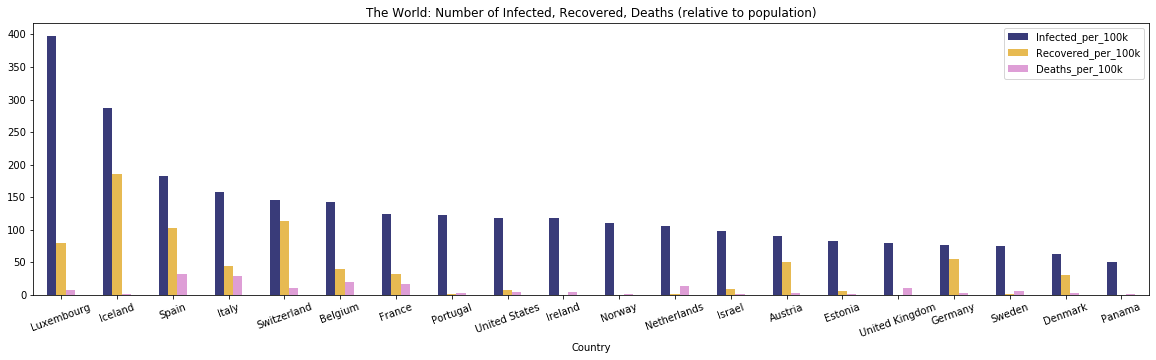

In [18]:
plot_bar('Infected_per_100k', continent = '', top_n = 20)

In [19]:
def plot_time(var, continent=None, top_n = None):


    df = df_prepare('data/covid_19_data.csv', 'data/population_2020_for_johnhopkins_data.csv',
                    historical = True,
                    continent = continent)

    # initializing the plot of df
    dic = dict()

    y = var
    group = 'Country'

    tot_countries = df.shape[0]
    
    if top_n:
        if top_n > tot_countries:
            top_n = tot_countries
    else:
        top_n = tot_countries
    
    
    
    fig, ax = plt.subplots()
    # key gives the group name (i.e. category), data gives the actual values

    last_date = df.index.max()
    
    df_last = df[df.index == last_date].sort_values(var, ascending=False)
    country_list = list(df_last[group][:top_n])
    
    for key, data in df.groupby(group):
        
        if key in country_list:
            
            data.plot(y=y, ax=ax, label=key, figsize=(15,8))

            dic[key] = data[y].iloc[-1]
        


    # re-arranging the order of lables, so that it matches the end points of the graphs
    current_handles, current_labels = plt.gca().get_legend_handles_labels()

    mydf = pd.DataFrame.from_dict(dic, orient='index', columns = [y])

    mydf['handles'] = current_handles
    mydf['labels'] = current_labels
    mydf = mydf.sort_values(by=[y], ascending=False)

    new_handles = list(mydf['handles'])
    new_labels = list(mydf['labels'])

    plt.legend(new_handles,new_labels)


    if not continent:
        continent = "The World"

    plt.title('{}: {} per Country'.format(continent, var))
    plt.ylabel('{}'.format(var));

In [129]:
def prepare_time(var, continent=None, top_n = None):


    df = df_prepare('data/covid_19_data.csv', 'data/population_2020_for_johnhopkins_data.csv',
                    historical = True,
                    continent = continent)

    
    # steps to add new metrics such as death rate
    
    countries = df.Country.unique()

    for i, country in enumerate(countries):
    
        days_delay = 14
    
        if i == 0:
        
        
            df1 = df.loc[df['Country'] == country]
            df1['Deaths_n_daysago'] = df1['Deaths'].shift(days_delay)
            df1['Mortality_rate'] = 100*df1['Deaths_n_daysago'] / (df1['Recovered'] + df1['Deaths_n_daysago'])
            df1['Recovered_in_n_days'] = df1['Deaths']*(1/(df1['Mortality_rate']/100 + 0.0000001) - 1)

        elif i > 0:

            df_single = df.loc[df['Country'] == country]
            df_single['Deaths_n_daysago'] = df_single['Deaths'].shift(days_delay)
            df_single['Mortality_rate'] = 100*df_single['Deaths_n_daysago'] / (df_single['Recovered'] + df_single['Deaths_n_daysago'])
            df_single['Recovered_in_n_days'] = df_single['Deaths']*(1/(df_single['Mortality_rate']/100 + 0.0000001) - 1)

            frames = [df1, df_single]
            df1 = pd.concat(frames)
            
    df = df1
    
    
    # initializing the plot of df
    dic = dict()

    y = var
    group = 'Country'

    tot_countries = df.shape[0]
    
    if top_n:
        if top_n > tot_countries:
            top_n = tot_countries
    else:
        top_n = tot_countries
    

    last_date = df.index.max()
    
    df_last = df[df.index == last_date].sort_values(var, ascending=False)
    countrylist = list(df_last[group][:top_n])
    
    df = df.reset_index()
    
    

    return countrylist, df

    

In [133]:
countrylist, df = prepare_time('Infected_percent', '', top_n = None)

/Users/truls/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/truls/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/truls/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

In [134]:
df

,Date,Continent,Country,Population,Infected,Recovered,Deaths,Infected_percent,Recovered_percent,Deaths_percent,Infected_per_100k,Recovered_per_100k,Deaths_per_100k,Deaths_n_daysago,Mortality_rate,Recovered_in_n_days
0,2020-02-24,Asia,Afghanistan,38928346.0,1.0,0.0,0.0,0.000003,0.0,0.000000,0.002569,0.0,0.000000,NaN,NaN,NaN
1,2020-02-25,Asia,Afghanistan,38928346.0,1.0,0.0,0.0,0.000003,0.0,0.000000,0.002569,0.0,0.000000,NaN,NaN,NaN
2,2020-02-26,Asia,Afghanistan,38928346.0,1.0,0.0,0.0,0.000003,0.0,0.000000,0.002569,0.0,0.000000,NaN,NaN,NaN
3,2020-02-27,Asia,Afghanistan,38928346.0,1.0,0.0,0.0,0.000003,0.0,0.000000,0.002569,0.0,0.000000,NaN,NaN,NaN
4,2020-02-28,Asia,Afghanistan,38928346.0,1.0,0.0,0.0,0.000003,0.0,0.000000,0.002569,0.0,0.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5082,2020-04-05,Africa,Zimbabwe,14862924.0,8.0,0.0,1.0,0.000054,0.0,0.000007,0.053825,0.0,0.006728,0.0,NaN,NaN
5083,2020-04-06,Africa,Zimbabwe,14862924.0,9.0,0.0,1.0,0.000061,0.0,0.000007,0.060553,0.0,0.006728,1.0,100.0,-9.999999e-08
5084,2020-04-07,Africa,Zimbabwe,14862924.0,9.0,0.0,2.0,0.000061,0.0,0.000013,0.060553,0.0,0.013456,1.0,100.0,-2.000000e-07
5085,2020-04-08,Africa,Zimbabwe,14862924.0,8.0,0.0,3.0,0.000054,0.0,0.000020,0.053825,0.0,0.020184,1.0,100.0,-3.000000e-07


In [127]:
df[df.Country == 'Germany']

,Date,Continent,Country,Population,Infected,Recovered,Deaths,Infected_percent,Recovered_percent,Deaths_percent,Infected_per_100k,Recovered_per_100k,Deaths_per_100k,Deaths_n_daysago,Mortality_rate,Recovered_in_n_days
610,2020-02-20,Europe,Germany,83783942.0,4.0,12.0,0.0,0.000005,0.000014,0.000000,0.004774,0.014323,0.000000,NaN,NaN,NaN
611,2020-02-21,Europe,Germany,83783942.0,2.0,14.0,0.0,0.000002,0.000017,0.000000,0.002387,0.016710,0.000000,NaN,NaN,NaN
612,2020-02-22,Europe,Germany,83783942.0,2.0,14.0,0.0,0.000002,0.000017,0.000000,0.002387,0.016710,0.000000,NaN,NaN,NaN
613,2020-02-23,Europe,Germany,83783942.0,2.0,14.0,0.0,0.000002,0.000017,0.000000,0.002387,0.016710,0.000000,NaN,NaN,NaN
614,2020-02-24,Europe,Germany,83783942.0,2.0,14.0,0.0,0.000002,0.000017,0.000000,0.002387,0.016710,0.000000,NaN,NaN,NaN
615,2020-02-25,Europe,Germany,83783942.0,3.0,14.0,0.0,0.000004,0.000017,0.000000,0.003581,0.016710,0.000000,NaN,NaN,NaN
616,2020-02-26,Europe,Germany,83783942.0,12.0,15.0,0.0,0.000014,0.000018,0.000000,0.014323,0.017903,0.000000,NaN,NaN,NaN
617,2020-02-27,Europe,Germany,83783942.0,30.0,16.0,0.0,0.000036,0.000019,0.000000,0.035806,0.019097,0.000000,NaN,NaN,NaN
618,2020-02-28,Europe,Germany,83783942.0,32.0,16.0,0.0,0.000038,0.000019,0.000000,0.038193,0.019097,0.000000,NaN,NaN,NaN
619,2020-02-29,Europe,Germany,83783942.0,63.0,16.0,0.0,0.000075,0.000019,0.000000,0.075193,0.019097,0.000000,NaN,NaN,NaN


In [128]:
countrylist

['Luxembourg',
 'Iceland',
 'Spain',
 'Italy',
 'Switzerland',
 'Belgium',
 'France',
 'Portugal',
 'Ireland',
 'Norway',
 'Netherlands',
 'Austria',
 'Estonia',
 'United Kingdom',
 'Germany']

In [24]:
df = df[df.Country.isin(countrylist)]

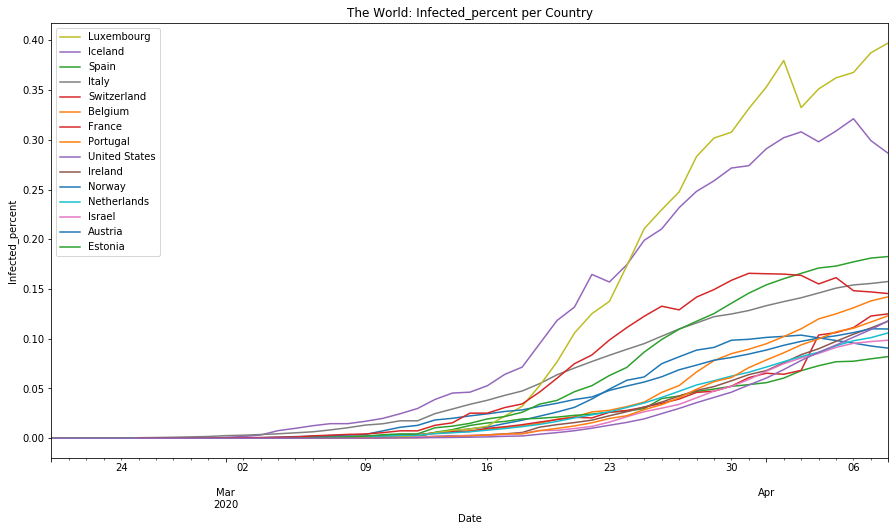

In [28]:
plot_time('Infected_percent', '', top_n = 15)

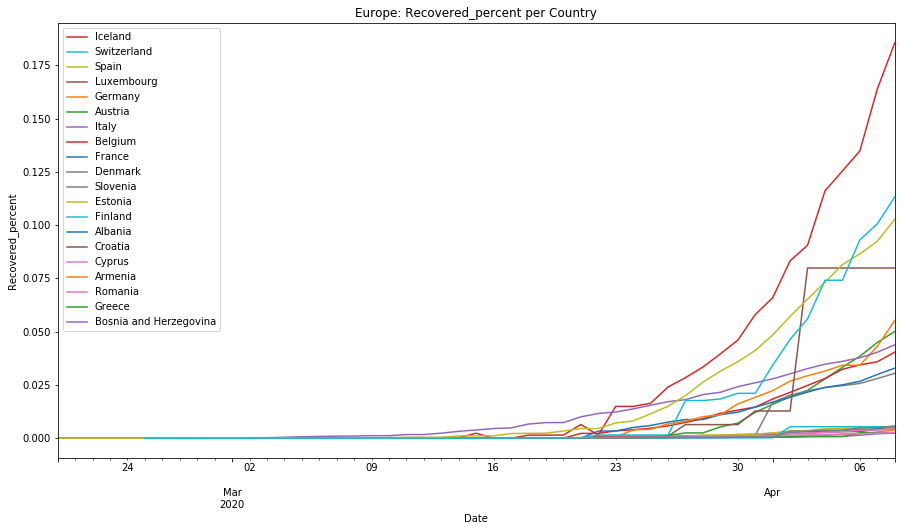

In [29]:
plot_time('Recovered_percent', 'Europe', top_n = 20)

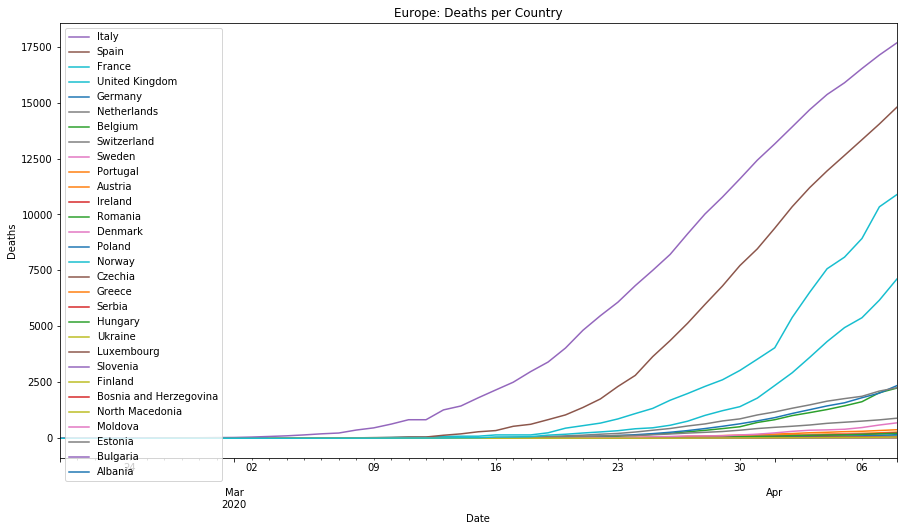

In [30]:
plot_time('Deaths', 'Europe', top_n = 30)

In [48]:
def prepare_geo():
    
    fp = 'data/ne_10m_admin_0_countries.shp'

    gdf = gpd.read_file(fp)
    
    gdf = gdf.rename(columns={"ADMIN": "Country", "ADM0_A3": "Short"})
    
    gdf = gdf[['Country', 'Short', 'geometry']]
    
    
    df_all = df_prepare('data/covid_19_data.csv', 'data/population_2020_for_johnhopkins_data.csv',
                    historical = False,
                    continent = None)
    
    
    
    df = gdf.merge(df_all, how='left', on='Short').drop(columns=['Date'])
    
    df.fillna(0, inplace = True)
    
    return df
    

### Totals

In [32]:
df = df_prepare('data/covid_19_data.csv', 'data/population_2020_for_johnhopkins_data.csv',
                    historical = False,
                    continent = None)
df_tot = pd.DataFrame(df.sum()).T

df_tot = df_tot[['Population', 'Infected', 'Recovered', 'Deaths']]

In [33]:
df_tot['Recovered_percent'] = 100*df_tot['Recovered']/(df_tot['Population'] + 1.0)
df_tot['Deaths_percent'] = 100*df_tot['Deaths']/(df_tot['Population'] + 1.0)
df_tot['Infected_percent'] = 100*df_tot['Infected']/(df_tot['Population'] + 1.0)
df_tot['Recovered_per_100k'] = 100000*df_tot['Recovered']/(df_tot['Population'] + 1.0)
df_tot['Deaths_per_100k'] = 100000*df_tot['Deaths']/(df_tot['Population'] + 1.0)
df_tot['Infected_per_100k'] = 100000*df_tot['Infected']/(df_tot['Population'] + 1.0)

In [34]:
df_tot

,Population,Infected,Recovered,Deaths,Recovered_percent,Deaths_percent,Infected_percent,Recovered_per_100k,Deaths_per_100k,Infected_per_100k
0,7.59026e+09,1.08890e+06,326882,88194,0.0043066,0.00116194,0.0143461,4.3066,1.16194,14.3461


### Shift (historical)

In [96]:


df = df_prepare('data/covid_19_data.csv', 'data/population_2020_for_johnhopkins_data.csv',
                    historical = True,
                    continent = 'Europe')

countries = df.Country.unique()

for i, country in enumerate(countries):
    
    days_delay = 18
    
    if i == 0:
        
        
        df1 = df.loc[df['Country'] == country]
        df1['Deaths_n_daysago'] = df1['Deaths'].shift(days_delay)
        df1['Mortality_rate'] = df1['Deaths_n_daysago'] / (df1['Recovered'] + df1['Deaths_n_daysago'])
        df1['Recovered_in_n_days'] = df1['Deaths']*(1/(df1['Mortality_rate'] + 0.0000001) - 1)

    elif i > 0:
    
        df_single = df.loc[df['Country'] == country]
        df_single['Deaths_n_daysago'] = df_single['Deaths'].shift(days_delay)
        df_single['Mortality_rate'] = df_single['Deaths_n_daysago'] / (df_single['Recovered'] + df_single['Deaths_n_daysago'])
        df_single['Recovered_in_n_days'] = df_single['Deaths']*(1/(df_single['Mortality_rate'] + 0.0000001) - 1)

        frames = [df1, df_single]
 
        df1 = pd.concat(frames)
df = df1

In [99]:
df

,Continent,Country,Population,Infected,Recovered,Deaths,Infected_percent,Recovered_percent,Deaths_percent,Infected_per_100k,Recovered_per_100k,Deaths_per_100k
Date,,,,,,,,,,,,
2020-03-09,Europe,Albania,2877797.0,2.0,0.0,0.0,0.000069,0.000000,0.000000,0.069498,0.000000,0.000000
2020-03-10,Europe,Albania,2877797.0,10.0,0.0,0.0,0.000347,0.000000,0.000000,0.347488,0.000000,0.000000
2020-03-11,Europe,Albania,2877797.0,11.0,0.0,1.0,0.000382,0.000000,0.000035,0.382237,0.000000,0.034749
2020-03-12,Europe,Albania,2877797.0,22.0,0.0,1.0,0.000764,0.000000,0.000035,0.764473,0.000000,0.034749
2020-03-13,Europe,Albania,2877797.0,32.0,0.0,1.0,0.001112,0.000000,0.000035,1.111961,0.000000,0.034749
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-04,Europe,United Kingdom,67886011.0,37942.0,215.0,4320.0,0.055891,0.000317,0.006364,55.890748,0.316707,6.363608
2020-04-05,Europe,United Kingdom,67886011.0,43264.0,229.0,4943.0,0.063730,0.000337,0.007281,63.730360,0.337330,7.281323
2020-04-06,Europe,United Kingdom,67886011.0,46607.0,287.0,5385.0,0.068655,0.000423,0.007932,68.654792,0.422768,7.932415


In [100]:
df1.head(40)

,Continent,Country,Population,Infected,Recovered,Deaths,Infected_percent,Recovered_percent,Deaths_percent,Infected_per_100k,Recovered_per_100k,Deaths_per_100k,Deaths_n_daysago,Mortality_rate,Recovered_in_n_days
Date,,,,,,,,,,,,,,,
2020-03-09,Europe,Albania,2877797.0,2.0,0.0,0.0,0.000069,0.000000,0.000000,0.069498,0.000000,0.000000,NaN,NaN,NaN
2020-03-10,Europe,Albania,2877797.0,10.0,0.0,0.0,0.000347,0.000000,0.000000,0.347488,0.000000,0.000000,NaN,NaN,NaN
2020-03-11,Europe,Albania,2877797.0,11.0,0.0,1.0,0.000382,0.000000,0.000035,0.382237,0.000000,0.034749,NaN,NaN,NaN
2020-03-12,Europe,Albania,2877797.0,22.0,0.0,1.0,0.000764,0.000000,0.000035,0.764473,0.000000,0.034749,NaN,NaN,NaN
2020-03-13,Europe,Albania,2877797.0,32.0,0.0,1.0,0.001112,0.000000,0.000035,1.111961,0.000000,0.034749,NaN,NaN,NaN
2020-03-14,Europe,Albania,2877797.0,37.0,0.0,1.0,0.001286,0.000000,0.000035,1.285705,0.000000,0.034749,NaN,NaN,NaN
2020-03-15,Europe,Albania,2877797.0,41.0,0.0,1.0,0.001425,0.000000,0.000035,1.424700,0.000000,0.034749,NaN,NaN,NaN
2020-03-16,Europe,Albania,2877797.0,50.0,0.0,1.0,0.001737,0.000000,0.000035,1.737440,0.000000,0.034749,NaN,NaN,NaN
2020-03-17,Europe,Albania,2877797.0,54.0,0.0,1.0,0.001876,0.000000,0.000035,1.876435,0.000000,0.034749,NaN,NaN,NaN


In [59]:
last_date = str(df1.index[-1])[:10]


df_new = df1.loc[df1.index == last_date].fillna(0)

In [60]:
df_new

,Continent,Country,Population,Infected,Recovered,Deaths,Infected_percent,Recovered_percent,Deaths_percent,Infected_per_100k,Recovered_per_100k,Deaths_per_100k,Deaths_2weeksago,Death_rate,Recovered_proj_in_16_days,Recovered_in2weeks_est
Date,,,,,,,,,,,,,,,,
2020-04-08,Africa,Algeria,43851044.0,1130.0,237.0,205.0,0.002577,0.000540,0.000467,2.576906,0.540466,0.467492,21.0,0.081395,2313.568334,0.000000e+00
2020-04-08,Africa,Angola,32866272.0,15.0,2.0,2.0,0.000046,0.000006,0.000006,0.045639,0.006085,0.006085,0.0,0.000000,0.000000,2.000000e+07
2020-04-08,Africa,Benin,12123200.0,20.0,5.0,1.0,0.000165,0.000041,0.000008,0.164973,0.041243,0.008249,0.0,0.000000,0.000000,9.999999e+06
2020-04-08,Africa,Botswana,2254068.0,5.0,0.0,1.0,0.000222,0.000000,0.000044,0.221821,0.000000,0.044364,0.0,0.000000,0.000000,0.000000e+00
2020-04-08,Africa,Burkina Faso,20903273.0,257.0,134.0,23.0,0.001229,0.000641,0.000110,1.229472,0.641048,0.110031,4.0,0.028986,0.000000,7.704973e+02
2020-04-08,Africa,Burundi,11890784.0,3.0,0.0,0.0,0.000025,0.000000,0.000000,0.025230,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00
2020-04-08,Africa,Cameroon,26545863.0,660.0,60.0,10.0,0.002486,0.000226,0.000038,2.486263,0.226024,0.037671,1.0,0.016393,0.000000,5.999963e+02
2020-04-08,Africa,Central African Republic,4829767.0,8.0,0.0,0.0,0.000166,0.000000,0.000000,0.165639,0.000000,0.000000,0.0,0.000000,0.000000,0.000000e+00
2020-04-08,Africa,Chad,16425864.0,8.0,2.0,0.0,0.000049,0.000012,0.000000,0.048704,0.012176,0.000000,0.0,0.000000,0.000000,0.000000e+00


In [41]:
usa = df[df['Country'] == 'United States']

In [42]:
usa['Deaths_2weeksago'] = usa['Deaths'].shift(14)

/Users/truls/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [43]:
usa['Death_rate'] = usa['Deaths_2weeksago'] / (usa['Recovered'] + usa['Deaths_2weeksago'])

/Users/truls/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [44]:
usa['Recovered_in2weeks_est'] = usa['Deaths']*(1/(usa['Death_rate'] + 0.0000001) - 1)

/Users/truls/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [45]:
usa.iloc[-1]

Continent                       America
Country                   United States
Population                  3.31003e+08
Infected                         390798
Recovered                         23559
Deaths                            14695
Infected_percent               0.118065
Recovered_percent            0.00711747
Deaths_percent               0.00443954
Infected_per_100k               118.065
Recovered_per_100k              7.11747
Deaths_per_100k                 4.43954
Deaths_2weeksago                    942
Death_rate                    0.0384474
Recovered_in2weeks_est           367514
Name: 2020-04-08 00:00:00, dtype: object

In [49]:
def plot_geo(colname, continent=None):
    
    
    data = prepare_geo()
    
    data = data[data.Country!="Antarctica"]

    if continent:
        data = data[data.Continent == continent] 

    fig, ax = plt.subplots(1, 1, figsize=(16, 12))
    
    
    if not continent:
        #ax.set(xlim=(-24, 40), ylim=(35, 75))
        fontsize = 6
    elif continent == 'Europe':
        ax.set(xlim=(-24, 40), ylim=(35, 75))
        fontsize = 8
        ax.text(1, 46, 'France', fontsize=fontsize)
        ax.text(8, 62, 'Norway', fontsize=fontsize)
        
    elif continent == 'America':
        ax.set(xlim=(-130, -30), ylim=(-55, 75))
        fontsize = 8        
    else:
        fontsize = 8

    

    data.plot(column=colname, ax=ax, legend=True, cmap='Wistia', legend_kwds={'label': "{}".format(colname), 
                                                                      'orientation': "vertical"})

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    #plt.xticks([10.7, 10.8, 10.9])
    #plt.yticks([59.8, 59.9, 60.0])
    #plt.suptitle('Marka', y=0.73, fontsize=10)

    plt.title('{}: {}\n'.format(continent, colname),  fontsize=18)
    
    #plt.axis('off')

    skip_list = ['Norway', 'France']

    for idx, row in data.iterrows():
        
        if (len(str(row['Country'])) > 3) & (str(row['Country']) not in skip_list):
            plt.annotate(s=row['Country'], xy=row['geometry'].centroid.coords[0],
                     horizontalalignment='center', fontsize=fontsize)

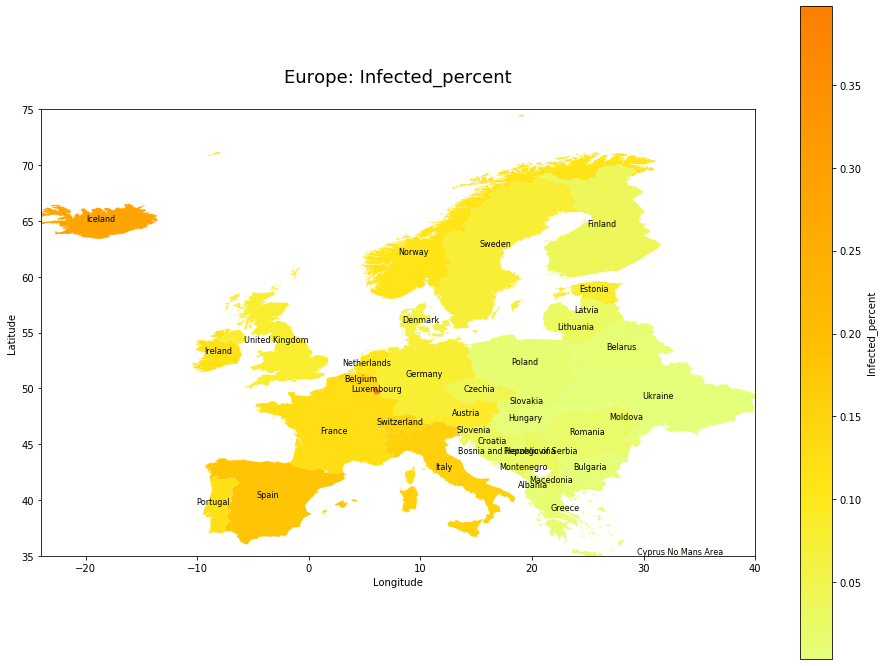

In [50]:
plot_geo(colname = 'Infected_percent', continent = 'Europe')

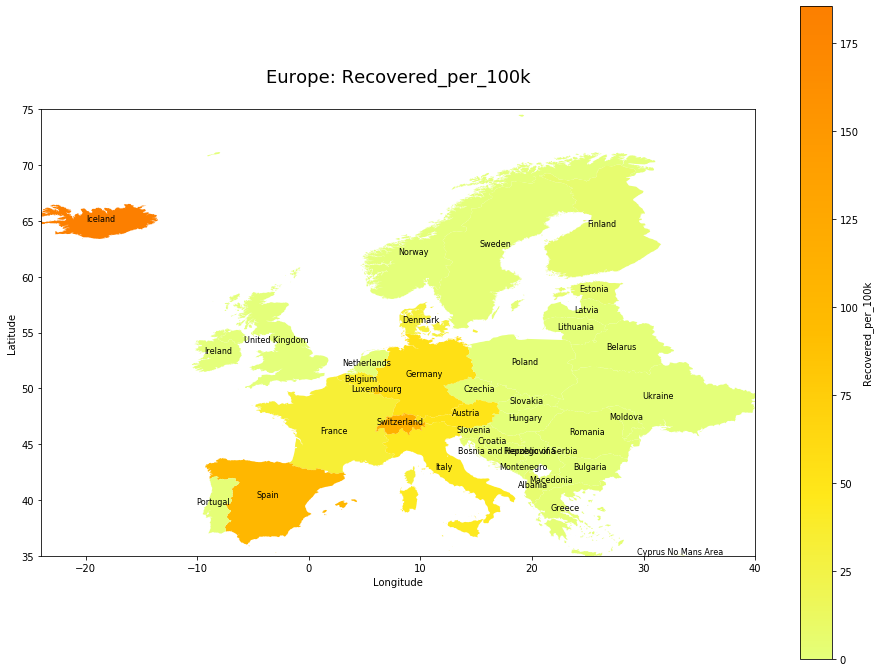

In [51]:
plot_geo(colname = 'Recovered_per_100k', continent = 'Europe')

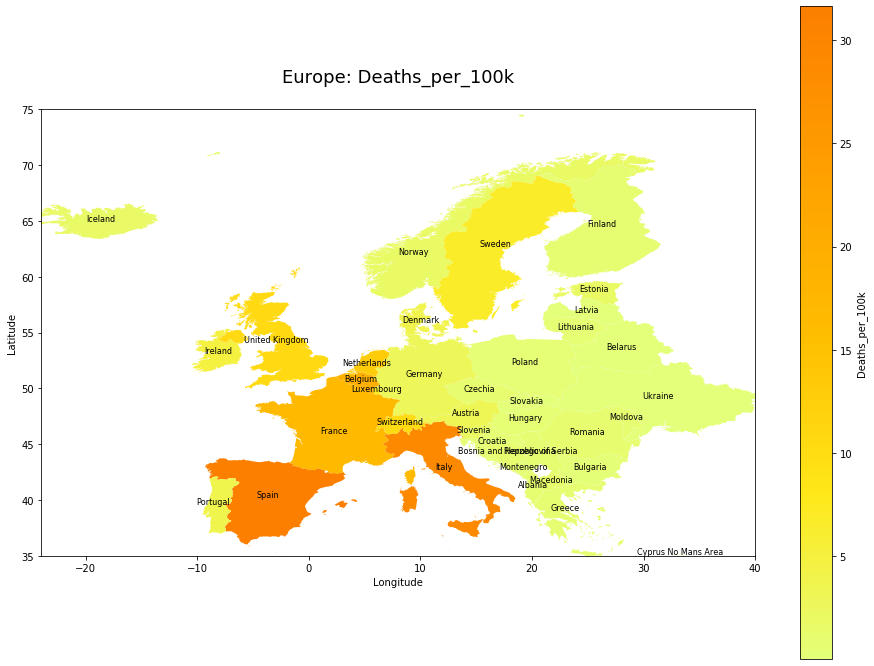

In [52]:
plot_geo(colname = 'Deaths_per_100k', continent = 'Europe')

In [53]:
dfx = prepare_geo()
fig = px.choropleth(dfx, locations="Short",
                    color="Infected_per_100k", # lifeExp is a column of gapminder
                    hover_name="Country", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

NameError: name 'px' is not defined

In [ ]:
dfx

In [ ]:
dfx = dfx.fillna(0)

In [ ]:
dfx = dfx[['Country', 'Short', 'Infected_per_100k']]

In [ ]:
dfx.sort_values('Infected_per_100k', ascending=False, inplace=True)

In [ ]:
countrylist = dfx.Country.unique().tolist()

In [ ]:
countrylist

In [ ]:
x_val = dfx[dfx['Country'] == 'Luxembourg'].Infected_per_100k.tolist()
x_val